In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import glob
import pandas as pd
import cv2
import gc
import numpy as np
import random
import imageio
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
#from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt

In [2]:
class CFG:
    epochs = 10
    batch_size = 32
    classes = ['BabyCrawling', 'Dancing', 'Drinking', 'Eating', 'Hug', 'Laughing', 'CuttingInKitchen', 'SitDown', 'Talking', 'WritingOnBoard']
    

In [3]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

## Changed output_size = (112,112) from (224,224)
def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=15):
    result = []
    src = cv2.VideoCapture(str(video_path))
    video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))
    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    
    for _ in range(n_frames):
        ret, frame = src.read()
        if not ret or frame is None:
            result.append(np.zeros((output_size[0], output_size[1], 3), dtype=np.float32))  # Append a blank frame
        else:
            frame = format_frames(frame, output_size)
            result.append(frame)
        
        for _ in range(frame_step - 1):
            src.grab()  # Skip frames

    src.release()
    result = np.array(result)[..., [2, 1, 0]]  # Convert BGR to RGB
    return result

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')

In [4]:
file_paths = []
targets = []
for i, cls in enumerate(CFG.classes):
    sub_file_paths = glob.glob(f"/kaggle/input/action45/Dataset/{cls}/**.mp4")[:100]
    file_paths += sub_file_paths
    targets += [i] * len(sub_file_paths)

In [5]:
features = []
for file_path in tqdm(file_paths):
    features.append(frames_from_video_file(file_path, n_frames = 10))
features = np.array(features)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
train_features, val_features, train_targets, val_targets = train_test_split(features, targets, test_size=0.2, random_state=42)
train_features.shape, val_features.shape, len(train_targets), len(val_targets)

((800, 10, 224, 224, 3), (200, 10, 224, 224, 3), 800, 200)

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_targets)).shuffle(CFG.batch_size * 4).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((val_features, val_targets)).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)


In [8]:
del train_features
del val_features
gc.collect()

18

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

def C3D_model(input_shape, num_classes):
    # C3D model architecture
    inputs = tf.keras.Input(shape=input_shape)
    
    x = layers.Conv3D(16, (3, 3, 3), padding="same", activation="relu")(inputs)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.Conv3D(32, (3, 3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.Conv3D(64, (3, 3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = models.Model(inputs, outputs)
    return model

# Model Compilation and Training
modelc = C3D_model(input_shape=(10, 224, 224, 3), num_classes=10)
modelc.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
 # Training
modelc.fit(train_ds, validation_data=(valid_ds), epochs=100, batch_size=32 )


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 424ms/step - accuracy: 0.1499 - loss: 2.2494 - val_accuracy: 0.1900 - val_loss: 2.1197
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step - accuracy: 0.2564 - loss: 1.9546 - val_accuracy: 0.2200 - val_loss: 1.9305
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - accuracy: 0.2666 - loss: 1.8257 - val_accuracy: 0.2550 - val_loss: 1.8711
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step - accuracy: 0.3063 - loss: 1.7567 - val_accuracy: 0.3100 - val_loss: 1.7814
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - accuracy: 0.3829 - loss: 1.6613 - val_accuracy: 0.3800 - val_loss: 1.6285
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step - accuracy: 0.4123 - loss: 1.5656 - val_accuracy: 0.3950 - val_loss: 1.5384
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - accuracy: 0.4159 - loss: 1.4729 - val_accuracy: 0.4050 - val_loss: 1.5067
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - accuracy: 0.4361 - loss: 1.4307 - val_acc

In [9]:
# Model Architecture

cnnmodel = tf.keras.Sequential([
    tf.keras.Input(shape=(10, 224,224, 3)),  # Increase sequence length
        
    tf.keras.layers.Conv3D(16, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)),
    tf.keras.layers.Conv3D(32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)),
    tf.keras.layers.Conv3D(64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)),
    tf.keras.layers.Conv3D(128, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Reshape((1, 128)),  
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)), 
    tf.keras.layers.GRU(32, activation='tanh'),
    tf.keras.layers.Dense(len(CFG.classes), activation="softmax")
])

# Compile Model with Dynamic Learning Rate
cnnmodel.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

# # Dynamic Learning Rate Scheduler
# lr_scheduler = ReduceLROnPlateau(
#     monitor="val_loss", patience=5, factor=0.5, min_lr=1e-5, verbose=1
# )
# Model Summary
cnnmodel.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 10, 224, 224, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 10, 112, 112, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 10, 112, 112, 32)    │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 10, 56, 56, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 10, 56, 56, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 10, 28, 28, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 10, 28, 28, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 10, 14, 14, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 14, 14, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling3d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling3D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 32)                  │          15,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 423,050 (1.61 MB)

 Trainable params: 423,050 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

# Train Model
history = cnnmodel.fit(
    train_ds, 
    validation_data=valid_ds,
    batch_size=32,
    epochs=100
)



Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 558ms/step - accuracy: 0.1249 - loss: 3.4092 - val_accuracy: 0.2050 - val_loss: 3.0073
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.1607 - loss: 2.8492 - val_accuracy: 0.2050 - val_loss: 2.4797
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step - accuracy: 0.2599 - loss: 2.3389 - val_accuracy: 0.1400 - val_loss: 2.3427
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 451ms/step - accuracy: 0.2828 - loss: 2.1590 - val_accuracy: 0.1600 - val_loss: 2.2066
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 451ms/step - accuracy: 0.2756 - loss: 2.0493 - val_accuracy: 0.1900 - val_loss: 2.0493
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 451ms/step - accuracy: 0.2793 - loss: 1.9510 - val_accuracy: 0.2350 - val_loss: 1.9801
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 451ms/step - accuracy: 0.2945 - loss: 1.8921 - val_accuracy: 0.2350 - val_loss: 1.9613
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 451ms/step - accuracy: 0.3120 - loss: 1.8581 - 

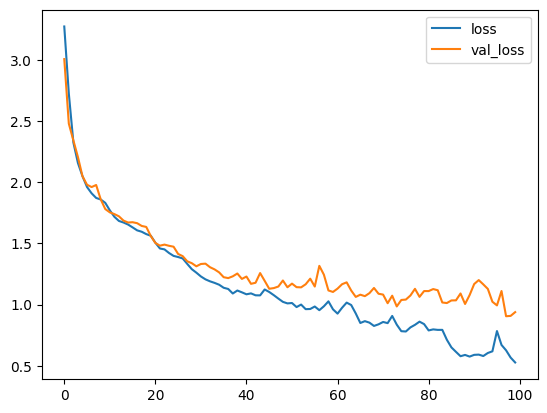

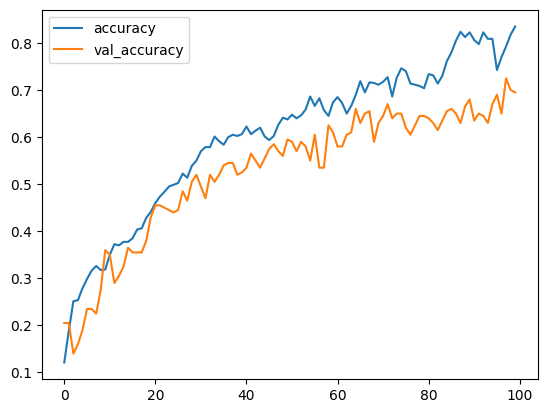

In [11]:
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()
    plt.show()

In [12]:
val_loss, val_acc = cnnmodel.evaluate(valid_ds)
print(f"Validation Loss:{val_loss} Validation Accuracy:{val_acc}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.6599 - loss: 1.0229
Validation Loss:0.9388759136199951 Validation Accuracy:0.6949999928474426


In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(class_names), len(class_names)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


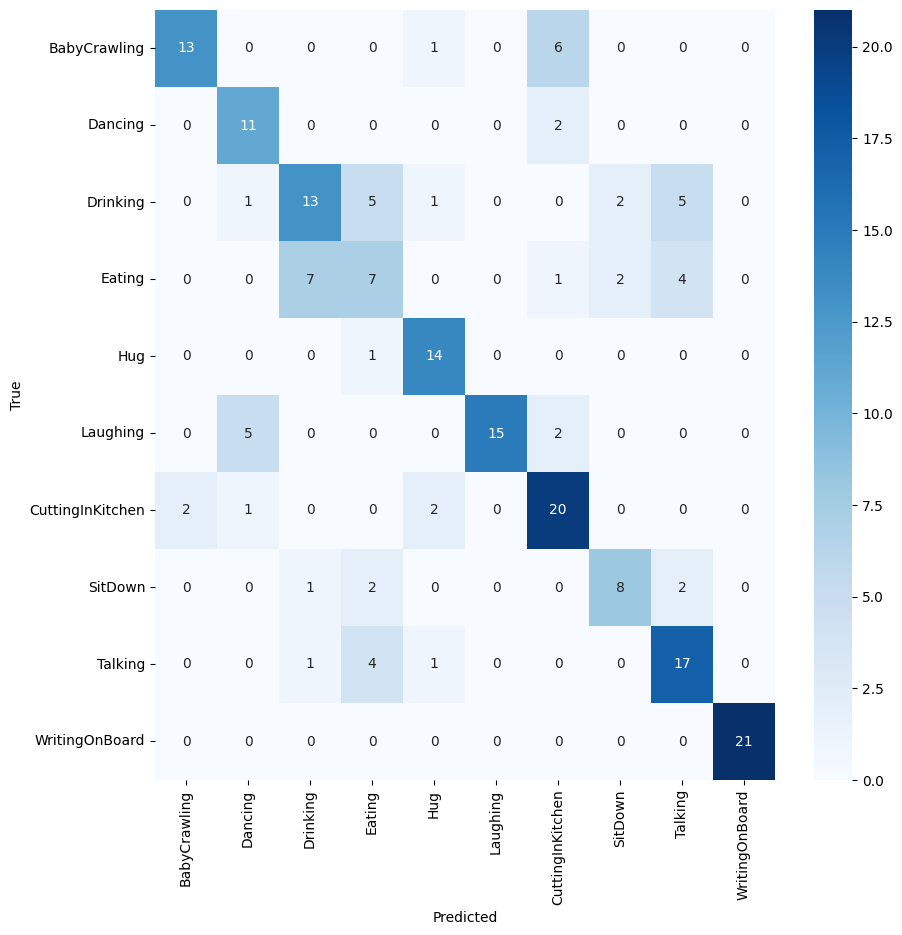

In [14]:
val_predictions = np.argmax(cnnmodel.predict(valid_ds), axis=1)
plot_confusion_matrix(val_targets, val_predictions, CFG.classes)

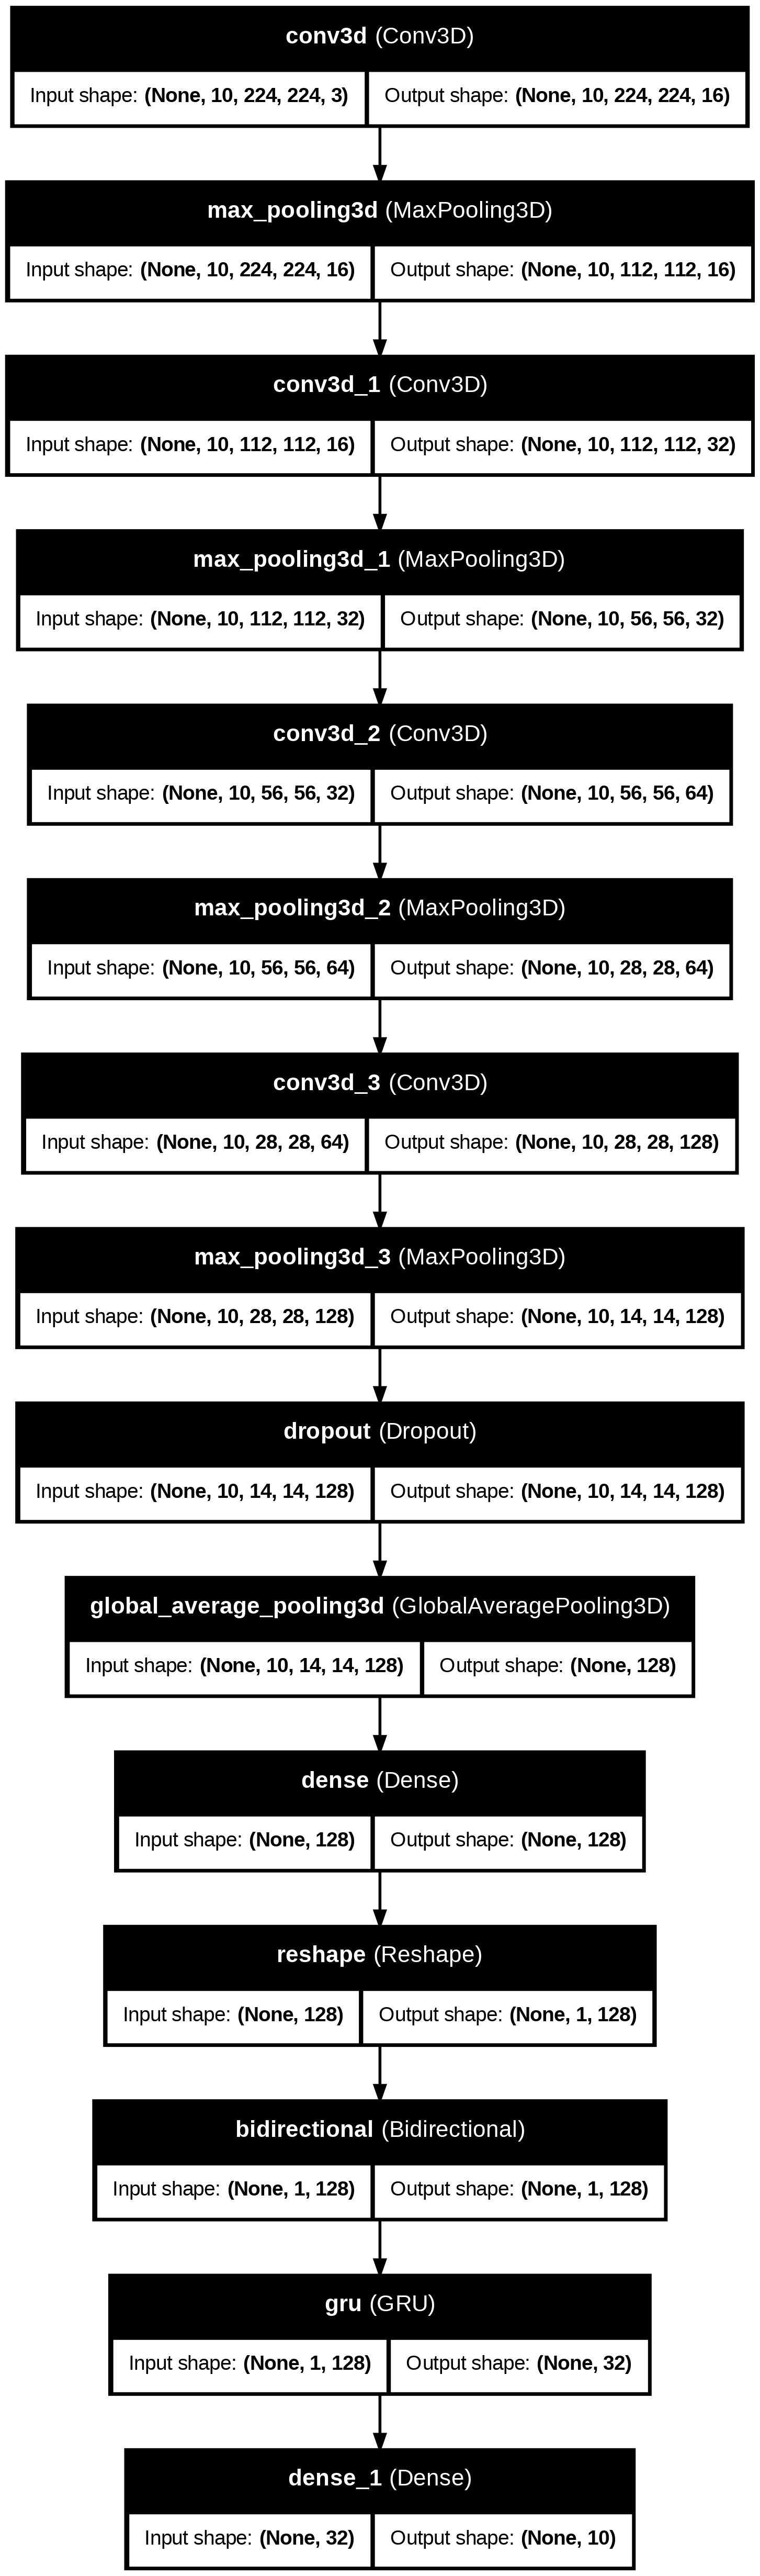

In [15]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Save the model architecture to an image
plot_model(cnnmodel, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, expand_nested=True)


In [16]:
pip install visualkeras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 39.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


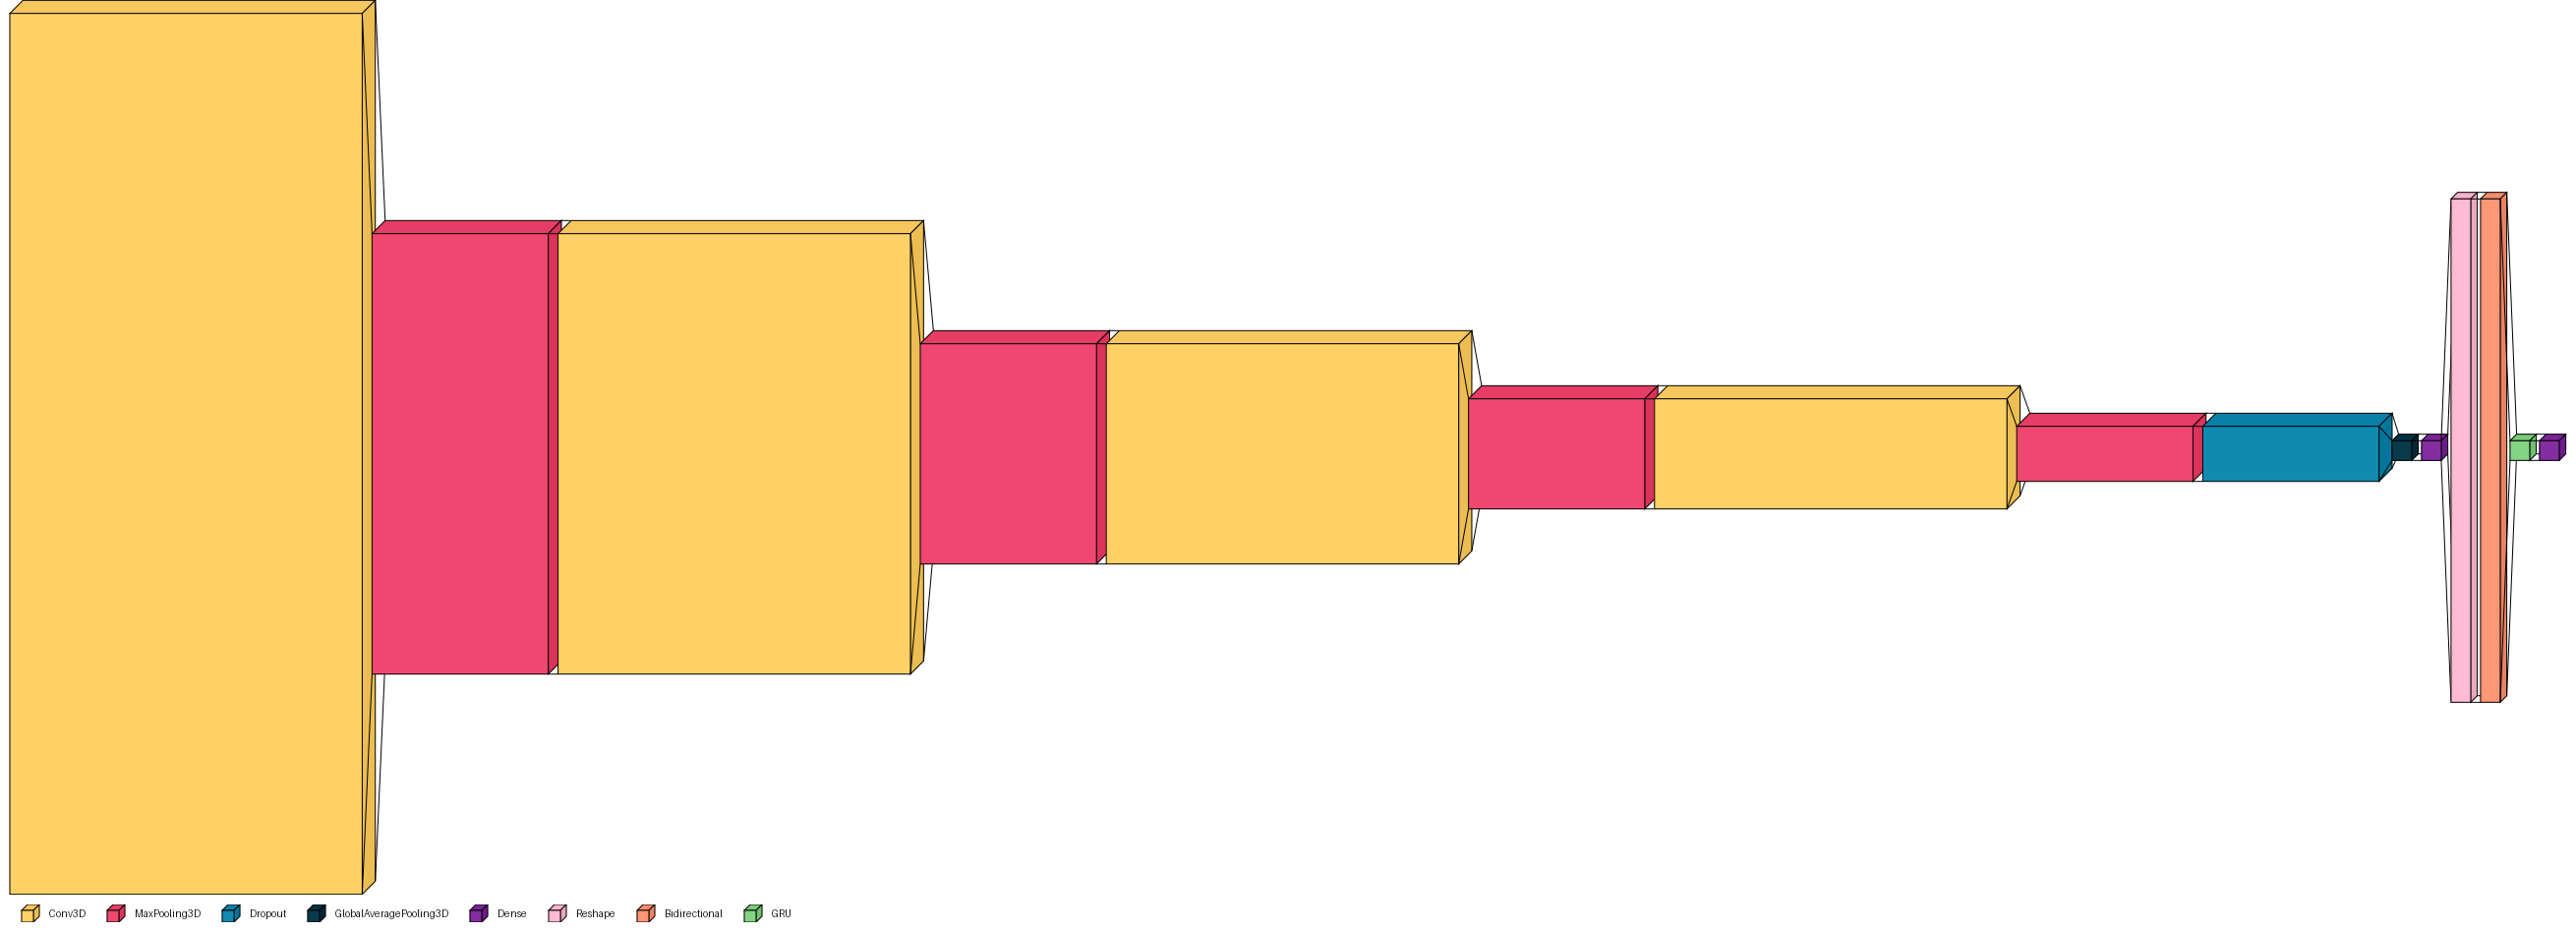

In [17]:
import visualkeras
from PIL import ImageFont

# Visualize the model
visualkeras.layered_view(cnnmodel, legend=True, draw_volume=True)


In [19]:
import tensorflow as tf

# Load the trained EfficientNet model
model = tf.keras.models.load_model("/kaggle/input/models/effmodel.h5")


In [ ]:
file_paths = []
targets = []
for i, cls in enumerate(CFG.classes):
    sub_file_paths = glob.glob(f"/kaggle/input/action45/Dataset/{cls}/**.mp4")[:100]
    file_paths += sub_file_paths
    targets += [i] * len(sub_file_paths)

In [24]:
import cv2
import numpy as np

def preprocess_video(video_path, n_frames=10, img_size=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, n_frames, dtype=int)

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, img_size)
        frame = frame / 255.0  # Normalize
        frames.append(frame)

    cap.release()
    frames = np.array(frames)  # Shape: (n_frames, 224, 224, 3)
    return frames

# Load a video and preprocess

video_data = preprocess_video(file_paths[678])
video_data = np.expand_dims(video_data, axis=0)  # Add batch dimension (1, frames, H, W, C)


In [25]:
# Predict the action
predictions = model.predict(video_data)
predicted_class = np.argmax(predictions)  # Get the class with highest probability

# If class names are available
class_names = ['BabyCrawling', 'Dancing', 'Drinking', 'Eating', 'Hug', 
               'Laughing', 'CuttingInKitchen', 'SitDown', 'Talking', 'WritingOnBoard']

print(f"Predicted Action: {class_names[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Action: CuttingInKitchen
